## 尝试加速MLD算法

我们发现虽然每个detector所连接的边和节点都是有限的，由于计算分布的规模随着边数量的增加而指数增加，因此依旧是一个比较大的数，最大可能为：
$$2^{81}$$
这是一个很大的数，因此我们需要加速算法。

我们考虑一个d=5，r=7的示例。

In [1]:
import MLD
import stim

In [2]:
circuit_noisy = stim.Circuit.from_file("./data/surface_code_bZ_d5_r07_center_5_5/circuit_noisy.stim")

detector_error_model = circuit_noisy.detector_error_model()

In [3]:
ml_decoder = MLD.MaxLikelihoodDecoder(detector_error_model,detector_error_model.num_detectors)
ml_decoder.compute_detector_number_distribution()

{'D0': 19,
 'D3': 11,
 'D17': 55,
 'D4': 22,
 'D13': 46,
 'D16': 58,
 'D18': 59,
 'D19': 68,
 'L0': 207,
 'D1': 19,
 'D23': 70,
 'D5': 11,
 'D22': 48,
 'D26': 16,
 'D27': 50,
 'D2': 3,
 'D6': 22,
 'D14': 28,
 'D20': 56,
 'D24': 70,
 'D7': 22,
 'D28': 71,
 'D30': 53,
 'D8': 3,
 'D33': 18,
 'D9': 10,
 'D25': 43,
 'D10': 19,
 'D29': 56,
 'D31': 54,
 'D11': 8,
 'D34': 38,
 'D21': 26,
 'D32': 20,
 'D35': 10,
 'D12': 20,
 'D41': 68,
 'D37': 52,
 'D40': 64,
 'D36': 22,
 'D15': 28,
 'D42': 68,
 'D43': 80,
 'D44': 64,
 'D38': 28,
 'D47': 80,
 'D46': 56,
 'D39': 28,
 'D48': 80,
 'D49': 56,
 'D51': 64,
 'D50': 26,
 'D52': 80,
 'D53': 68,
 'D45': 26,
 'D54': 68,
 'D55': 64,
 'D56': 28,
 'D57': 28,
 'D58': 52,
 'D59': 22,
 'D65': 68,
 'D61': 52,
 'D64': 64,
 'D60': 22,
 'D66': 68,
 'D67': 80,
 'D68': 64,
 'D62': 28,
 'D71': 80,
 'D70': 56,
 'D63': 28,
 'D72': 80,
 'D73': 56,
 'D75': 64,
 'D74': 26,
 'D76': 80,
 'D77': 68,
 'D69': 26,
 'D78': 68,
 'D79': 64,
 'D80': 28,
 'D81': 28,
 'D82': 52,
 'D83

## 假设我们已知D43的值为0，对于D43的相关项，我们应该怎么处理？

In [4]:
D43_error_detector_model = {}

for error in detector_error_model:
    if error.type == "error":
        targets_copy = error.targets_copy()
        fliped_detector_observable_index = ml_decoder.get_detector_logical_observable_val(targets_copy, ml_decoder.detector_number)
        if 43 in fliped_detector_observable_index:
            probability = error.args_copy()[0]
            D43_error_detector_model[tuple(fliped_detector_observable_index)] = probability
            print(error)

error(0.00180976) D13 D16 D17 D43
error(0.000500323) D13 D16 D40 D43
error(0.00130303) D13 D16 D41 D43
error(0.000457248) D13 D17 D41 D43
error(0.00153124) D13 D40 D41 D43
error(0.00367973) D13 D43
error(0.000457248) D14 D16 D17 D43
error(0.000457248) D14 D16 D41 D43
error(0.00131259) D14 D17 D41 D43
error(0.000577662) D14 D17 D43
error(0.000577662) D14 D41 D43
error(0.00131259) D14 D43
error(0.00163785) D16 D17 D19 D43
error(0.00025984) D16 D17 D20 D43
error(0.000339969) D16 D19 D43 D47
error(0.000970795) D16 D19 D43 D48
error(0.00025984) D16 D20 D43 D48
error(0.00122997) D16 D40 D42 D43
error(0.000500323) D16 D41 D42 D43
error(0.00116262) D16 D42 D43 D47
error(0.000339969) D16 D42 D43 D48
error(0.00025984) D17 D19 D43 D48
error(0.00131677) D17 D20 D43 D48
error(0.000320939) D17 D20 D43 D49
error(0.00217206) D17 D41 D43 D44
error(0.000577662) D17 D43 D44
error(0.00237288) D17 D43 D44 D48
error(0.000320939) D17 D43 D44 D49
error(0.0320931) D19 D43
error(0.00126654) D19 D43 D47 D48
erro

多个错误事件同时发生的概率其实不大。

In [5]:
import itertools
probabilities = sorted(D43_error_detector_model.values(), reverse=True)

In [6]:
def get_i_error_even_probability(probabilities: list, i: int):
    """i个错误事件同时发生的概率

    Args:
        probabilities (list): 当前detector对应的所有错误事情
        i (int): i个错误事件发生
    """
    i_error_evens = itertools.combinations(range(len(probabilities)), i)
    i_error_even_probabilities = 0
    for error_even_index in i_error_evens:
        prob = 1
        for prob_index in range(len(probabilities)):
            if prob_index in error_even_index:
                prob = prob * probabilities[prob_index]
            else:
                prob = prob * (1 - probabilities[prob_index])
        i_error_even_probabilities += prob
    return i_error_even_probabilities

In [7]:
# for i in range(1,5):
#     i_probability = get_i_error_even_probability(probabilities=probabilities, i=i)
#     print(f"{i}个错误事件同时发生的概率为{i_probability}")

假设，我们不考虑，错误事件组合，使得发生10^{-15}的概率。

In [8]:
probabilities[0]*probabilities[1]*probabilities[2]*probabilities[3]*probabilities[4]*probabilities[5]*probabilities[6]*probabilities[7]

8.104974546600419e-15

假设为1，则可能的组合是1,3,5,7.
假设为0，则可能的组合为0,2,4,6.

上面设置的10^{-15}次方，和其他时间发生，值应该更小，但是也存在一些可以合并的情况，可能对应会增加。

这个值如何设置，或者设置这个值是否会带来误差，需要进行思考。

因为，本身是probability存在顺序，因此我们可以有一定的优化：

In [9]:
probabilities

[0.03209314439133004,
 0.03209314439133004,
 0.018217423062421856,
 0.014759755055715348,
 0.014566244437595306,
 0.014566244437595306,
 0.011744456314717388,
 0.011744456314717388,
 0.011440706458813104,
 0.008704607463930172,
 0.003679729432590249,
 0.0035765165723576037,
 0.002372880000104484,
 0.0021720613961547534,
 0.0018097649976214288,
 0.001642474710774992,
 0.0016378526356232723,
 0.0016378526356232723,
 0.001553108689026702,
 0.001541012847976231,
 0.0015312353629818934,
 0.001494935687764309,
 0.0014402115842943254,
 0.0013167694462953802,
 0.0013167694462953802,
 0.0013125946963400423,
 0.0013125946963400423,
 0.0013030340896023013,
 0.001277933125358692,
 0.0012665431220169816,
 0.0012665431220169816,
 0.0012299675340994892,
 0.00116261892345543,
 0.001106268851653764,
 0.0010206214357338142,
 0.0010206214357338142,
 0.001012104479087138,
 0.001012104479087138,
 0.0009707951757025881,
 0.0009707951757025881,
 0.0005776624679265652,
 0.0005776624679265652,
 0.0005776624679

* 基于具体的测量值，为0则只能是偶数个错误事件发生，为1只能是奇数个错误事件发生。
* 错误翻转是由几个错误事件发生而来。（多个错误事件发生，对应的概率会比较小）

因此，我们可以考虑设置一个阈值，选择出概率大于阈值的错误事件组合。

这个后续继续考虑

简单探索一下随着d和r的增加，在线MLD的S_{max}变化。

In [10]:
# # for d in range(3, 8, 2):
# for r in range(1, 12, 2):
#     # print(f"------------------------r:{r}, d:{d}-------------------------")
#     logging.info(f"----------------------r: {r}, d: {d}-------------------------")
#     surface_code_circuit = stim.Circuit.generated(
#         "surface_code:rotated_memory_z",
#         rounds=r,
#         distance=3,
#         after_clifford_depolarization=0.001,
#         after_reset_flip_probability=0.002,
#         before_measure_flip_probability=0.004,
#         before_round_data_depolarization=0.003)
    
#     surface_code_detector_model = surface_code_circuit.detector_error_model()
#     ml_decoder = MLD.MaxLikelihoodDecoder(surface_code_detector_model, surface_code_detector_model.num_detectors)
    
#     n=1
#     syndrome = "1"*n + "0"*(ml_decoder.detector_number-n)

#     setup_logging(environment='development', log_file_name = "speed_up_mld_d_3_r.log")
#     ml_decoder.decode([syndrome])

输出按照顺序解码，每一步计算概率分布过程信息。

d=3的情况下，随着r的增加，最大值最大为2048.
d=5的情况下，随着r=3的情况下，难以快速计算，放到Linux 服务器中运行。

## d=3, r=3的并行在线MLD示例

In [11]:
import MLD
import stim

circuit_noisy = stim.Circuit.from_file("./data/surface_code_bZ_d3_r03_center_3_5/circuit_noisy.stim")

detector_error_model = circuit_noisy.detector_error_model()

在均匀的噪声模型下，得到的基本情况为：
```
L0:35
max_key:D9, max_value:48
connected_detector len:12
max connectivity detector coordinates: [2.0, 4.0, 1.0]
max connectivity detector: D9, detector indexs: [2, 5, 6, 8, 10, 13, 24, 12, 16, 7, 14, 11, 17], detector indexs len: 13
max connectivity detector's connected detector coordinates: [[4.0, 4.0, 0.0], [2.0, 2.0, 1.0], [4.0, 2.0, 1.0], [0.0, 4.0, 1.0], [4.0, 4.0, 1.0], [2.0, 2.0, 2.0], [2.0, 0.0, 2.0], [0.0, 4.0, 2.0], [6.0, 2.0, 1.0], [4.0, 2.0, 2.0], [4.0, 6.0, 1.0], [2.0, 4.0, 2.0]]
detector_error_model_number:24
```

意思是，在d=3, r=3的模型下，存在24个检测器（detector），其中最大连接数量的detector为D9，其相连的边数为48，其相连的detector数为13（因为是超图，所以连接边数!=连接节点数）。

D9对应的坐标为[2.0, 4.0, 1.0]，其连接的detector为[[4.0, 4.0, 0.0], [2.0, 2.0, 1.0], [4.0, 2.0, 1.0], [0.0, 4.0, 1.0], [4.0, 4.0, 1.0], [2.0, 2.0, 2.0], [2.0, 0.0, 2.0], [0.0, 4.0, 2.0], [6.0, 2.0, 1.0], [4.0, 2.0, 2.0], [4.0, 6.0, 1.0], [2.0, 4.0, 2.0]].

In [12]:
detector_error_model

stim.DetectorErrorModel('''
    error(0.00538601) D0 D2
    error(0.00455203) D0 D2 D8
    error(0.00341035) D0 D3
    error(0.0287947) D0 D5
    error(0.000418444) D0 D5 D7
    error(0.00163539) D0 D5 D7 D8
    error(0.00232627) D0 D5 D8
    error(0.000500323) D0 D7 D8 D9
    error(0.00153124) D0 D7 D8 D10
    error(0.000418444) D0 D7 D8 L0
    error(0.00167586) D0 D7 D9
    error(0.000500323) D0 D7 D10
    error(0.00480341) D0 D7 L0
    error(0.000500323) D0 D8 D9
    error(0.00175909) D0 D8 D10
    error(0.000418444) D0 D8 L0
    error(0.00167586) D0 D9
    error(0.00547618) D0 D10
    error(0.00897529) D0 L0
    error(0.00400415) D1 D3
    error(0.0299506) D1 D9
    error(0.00278521) D1 L0
    error(0.00724199) D2
    error(0.00244636) D2 D5
    error(0.00244636) D2 D5 D8
    error(0.0231764) D2 D6
    error(0.00218788) D2 D6 D8
    error(0.00244473) D2 D8
    error(0.00234426) D2 D8 D10
    error(0.00234426) D2 D10
    error(0.0121274) D3
    error(0.00257744) D3 D9
    error(0.00

我们发现上面的错误事件数为219个。

我们先按照detector的序列顺序，执行在线的MLD算法。

In [13]:
ml_decoder = MLD.MaxLikelihoodDecoder(detector_error_model,detector_error_model.num_detectors)

ml_decoder.compute_detector_number_distribution()

{'D0': 19,
 'D2': 10,
 'D8': 43,
 'D3': 8,
 'D5': 45,
 'D7': 48,
 'D9': 16,
 'D10': 34,
 'L0': 35,
 'D1': 3,
 'D6': 26,
 'D11': 10,
 'D4': 20,
 'D16': 48,
 'D13': 34,
 'D15': 43,
 'D12': 10,
 'D18': 45,
 'D17': 26,
 'D14': 16,
 'D19': 20,
 'D20': 8,
 'D23': 19,
 'D21': 10,
 'D22': 3}

In [14]:
ml_decoder.compute_detector_connectivity()

{'D0': [2, 8, 3, 5, 7, 9, 10, 24],
 'D2': [0, 8, 5, 6, 10],
 'D8': [0, 2, 5, 7, 9, 10, 24, 6, 16, 18, 11, 19],
 'D3': [0, 1, 9, 11, 10],
 'D5': [0, 7, 8, 2, 4, 6, 16, 24, 13, 15, 10, 18, 17],
 'D7': [0, 5, 8, 9, 10, 24, 4, 6, 16, 18, 15, 17, 19],
 'D9': [0, 7, 8, 1, 3, 11, 10, 17, 24],
 'D10': [0, 7, 8, 2, 3, 11, 5, 9, 18, 17, 19],
 'L0': [0, 7, 8, 1, 4, 5, 15, 16, 12, 13, 9, 17, 20, 21],
 'D1': [3, 9, 24],
 'D6': [2, 8, 4, 5, 16, 13, 7, 18, 14],
 'D11': [3, 9, 10, 8, 19],
 'D4': [5, 6, 16, 7, 24, 13, 15, 12],
 'D16': [4, 5, 6, 13, 24, 7, 8, 17, 18, 15, 14, 23, 19],
 'D13': [4, 5, 15, 16, 6, 12, 24, 14, 20, 18, 23, 21],
 'D15': [4, 5, 13, 24, 7, 17, 18, 16, 12, 14, 23, 21],
 'D12': [4, 13, 24, 14, 15, 20],
 'D18': [5, 7, 8, 15, 16, 6, 10, 19, 17, 13, 23, 21],
 'D17': [5, 7, 15, 16, 9, 10, 19, 18, 24, 21],
 'D14': [6, 16, 12, 13, 20, 15, 23, 22],
 'D19': [7, 10, 17, 18, 8, 11, 16],
 'D20': [12, 13, 14, 24, 22, 23],
 'D23': [13, 15, 16, 14, 18, 21, 20],
 'D21': [13, 15, 17, 18, 23, 24],


In [15]:
ml_decoder.compute_detector_connectivity(have_logical_observable=False)

{'D0': [2, 8, 3, 5, 7, 9, 10],
 'D2': [0, 8, 5, 6, 10],
 'D8': [0, 2, 5, 7, 9, 10, 6, 16, 18, 11, 19],
 'D3': [0, 1, 9, 11, 10],
 'D5': [0, 7, 8, 2, 4, 6, 16, 13, 15, 10, 18, 17],
 'D7': [0, 5, 8, 9, 10, 4, 6, 16, 18, 15, 17, 19],
 'D9': [0, 7, 8, 1, 3, 11, 10, 17],
 'D10': [0, 7, 8, 2, 3, 11, 5, 9, 18, 17, 19],
 'D1': [3, 9],
 'D6': [2, 8, 4, 5, 16, 13, 7, 18, 14],
 'D11': [3, 9, 10, 8, 19],
 'D4': [5, 6, 16, 7, 13, 15, 12],
 'D16': [4, 5, 6, 13, 7, 8, 17, 18, 15, 14, 23, 19],
 'D13': [4, 5, 15, 16, 6, 12, 14, 20, 18, 23, 21],
 'D15': [4, 5, 13, 7, 17, 18, 16, 12, 14, 23, 21],
 'D12': [4, 13, 14, 15, 20],
 'D18': [5, 7, 8, 15, 16, 6, 10, 19, 17, 13, 23, 21],
 'D17': [5, 7, 15, 16, 9, 10, 19, 18, 21],
 'D14': [6, 16, 12, 13, 20, 15, 23, 22],
 'D19': [7, 10, 17, 18, 8, 11, 16],
 'D20': [12, 13, 14, 22, 23],
 'D23': [13, 15, 16, 14, 18, 21, 20],
 'D21': [13, 15, 17, 18, 23],
 'D22': [14, 20]}

顺序在线的MLD解码

In [16]:
# 创建一个syndrome
import logging
from config import setup_logging

n=1
syndrome = "1"*n + "0"*(ml_decoder.detector_number-n)

setup_logging(environment='development', log_file_name = "speed_up_mld.log")
ml_decoder.decode([syndrome])

2024-10-12 17:16:50,608 - MLD - DEBUG - detector index: 0, uncomputed and connected edge number: 19, probability distribution length: 128
2024-10-12 17:16:50,612 - MLD - DEBUG - detector index: 1, uncomputed and connected edge number: 3, probability distribution length: 128
2024-10-12 17:16:50,624 - MLD - DEBUG - detector index: 2, uncomputed and connected edge number: 8, probability distribution length: 256
2024-10-12 17:16:50,632 - MLD - DEBUG - detector index: 3, uncomputed and connected edge number: 6, probability distribution length: 256
2024-10-12 17:16:50,977 - MLD - DEBUG - detector index: 4, uncomputed and connected edge number: 20, probability distribution length: 4096
2024-10-12 17:16:52,484 - MLD - DEBUG - detector index: 5, uncomputed and connected edge number: 30, probability distribution length: 8192
2024-10-12 17:16:53,046 - MLD - DEBUG - detector index: 6, uncomputed and connected edge number: 14, probability distribution length: 8192
2024-10-12 17:16:54,194 - MLD - DE

[0]

按照简单的情况进行拆分。

我们首先选择D_0作为初始节点。'D0': [2, 8, 3, 5, 7, 9, 10, 24]，其中24表示的是L0.

In [17]:
detector_connectivity = ml_decoder.compute_detector_connectivity(have_logical_observable=False)
detector_connectivity["D0"]

[2, 8, 3, 5, 7, 9, 10]

我们可以从非detector_connectivity["D0"]中，选择其中一个作为不相邻的detector来并行执行。

不相邻的节点有很多，我们暂时按照顺序，选择最小序号的detector作为并行执行的节点。
其他选择策略：
* 选择相邻节点数最小，序号最小。
* 选择连接的边数最小，序号最小。

我们暂时先考虑最简单的策略。

我们维护几个list：
* 当前可并行执行的detector，即和该轮执行的节点不相邻：Current_parallel_detector_candidates。（每轮变化，一轮不可能并行执行完所有的detector，需要多轮，在每轮的时候，需要尽可能将能够并行的节点都并行执行）
* Current_parallel_detectors：当前轮，可以并行执行的detector。
* 当所有detector都执行完了，就计算出了最终的概率分布。当前未执行的detector，即还没有进行错误事件合并的剩余detector：unexecuted_detectors。（每轮不可能并行执行完所有的detector，用该list存储下来）

In [18]:
# init the list
current_parallel_detector_candidates = list(range(ml_decoder.detector_number))
unexecuted_detectors = list(range(ml_decoder.detector_number))
current_parallel_detectors = []


# 选择D0，选择序号最小的节点：
detector = current_parallel_detector_candidates.pop(0)
current_parallel_detectors.append(detector)
unexecuted_detectors.remove(detector)

# 更新current_parallel_detector_candidates，找到所有与current_parallel_detectors不相邻的节点。
current_parallel_detector_candidates = [i for i in current_parallel_detector_candidates if i not in detector_connectivity[f"D{detector}"]]
print(f"当前并行执行的节点: {detector}")
print("当前相邻节点", detector_connectivity[f"D{detector}"])
print("后续可以选择的非相邻可并行节点",current_parallel_detector_candidates)
print("当前未执行的节点", unexecuted_detectors)
# 选择current_parallel_detector_candidates中序号最小的节点。

detector = current_parallel_detector_candidates.pop(0)
current_parallel_detectors.append(detector)
unexecuted_detectors.remove(detector)

# 更新current_parallel_detector_candidates，找到所有与current_parallel_detectors不相邻的节点。
current_parallel_detector_candidates = [i for i in current_parallel_detector_candidates if i not in detector_connectivity[f"D{detector}"]]
print(f"当前并行执行的节点: {detector}")
print("当前相邻节点", detector_connectivity[f"D{detector}"])
print("后续可以选择的非相邻可并行节点",current_parallel_detector_candidates)
print("当前未执行的节点", unexecuted_detectors)


当前并行执行的节点: 0
当前相邻节点 [2, 8, 3, 5, 7, 9, 10]
后续可以选择的非相邻可并行节点 [1, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 1
当前相邻节点 [3, 9]
后续可以选择的非相邻可并行节点 [4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


将上述代码转化为while循环，直到current_parallel_detector_candidates为空。

In [19]:
current_parallel_detector_candidates = list(range(ml_decoder.detector_number))
unexecuted_detectors = list(range(ml_decoder.detector_number))
current_parallel_detectors = []


while current_parallel_detector_candidates:
    detector = current_parallel_detector_candidates.pop(0)
    current_parallel_detectors.append(detector)
    unexecuted_detectors.remove(detector)

    # 更新current_parallel_detector_candidates，找到所有与current_parallel_detectors不相邻的节点。
    current_parallel_detector_candidates = [i for i in current_parallel_detector_candidates if i not in detector_connectivity[f"D{detector}"]]
    print(f"当前并行执行的节点: {detector}")
    print("当前相邻节点", detector_connectivity[f"D{detector}"])
    print("后续可以选择的非相邻可并行节点",current_parallel_detector_candidates)
    print("当前未执行的节点", unexecuted_detectors)

当前并行执行的节点: 0
当前相邻节点 [2, 8, 3, 5, 7, 9, 10]
后续可以选择的非相邻可并行节点 [1, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 1
当前相邻节点 [3, 9]
后续可以选择的非相邻可并行节点 [4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 4
当前相邻节点 [5, 6, 16, 7, 13, 15, 12]
后续可以选择的非相邻可并行节点 [11, 14, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 11
当前相邻节点 [3, 9, 10, 8, 19]
后续可以选择的非相邻可并行节点 [14, 17, 18, 20, 21, 22, 23]
当前未执行的节点 [2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 14
当前相邻节点 [6, 16, 12, 13, 20, 15, 23, 22]
后续可以选择的非相邻可并行节点 [17, 18, 21]
当前未执行的节点 [2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 17
当前相邻节点 [5, 7, 15, 16, 9, 10, 19, 18, 21]
后续可以选择的非相邻可并行节点 []
当前未执行的

将上述代码转换为while循环，直到unexecuted_detectors为空。

In [20]:
current_parallel_detector_candidates = list(range(ml_decoder.detector_number))
unexecuted_detectors = list(range(ml_decoder.detector_number))

# 轮次
num_rounds = 0

while unexecuted_detectors:
    # 多轮进行并行执行：
    # print(f"--------------第{num_rounds}轮--------------------")
    # 初始化list
    current_parallel_detector_candidates = unexecuted_detectors.copy()
    current_parallel_detectors = []
    
    while current_parallel_detector_candidates:
        detector = current_parallel_detector_candidates.pop(0)
        current_parallel_detectors.append(detector)
        unexecuted_detectors.remove(detector)

        # 更新current_parallel_detector_candidates，找到所有与current_parallel_detectors不相邻的节点。
        current_parallel_detector_candidates = [i for i in current_parallel_detector_candidates if i not in detector_connectivity[f"D{detector}"]]
        print(f"当前并行执行的节点: {detector}")
        connected_detector = detector_connectivity[f"D{detector}"]
        print(f"当前相邻节点: {connected_detector}, 相邻节点数：{len(connected_detector)}")
        print("后续可以选择的非相邻可并行节点",current_parallel_detector_candidates)
        print("当前未执行的节点", unexecuted_detectors)
    
    
    num_rounds += 1
    print(f"--------------第{num_rounds}轮执行的节点: {current_parallel_detectors}------------")
    

当前并行执行的节点: 0
当前相邻节点: [2, 8, 3, 5, 7, 9, 10], 相邻节点数：7
后续可以选择的非相邻可并行节点 [1, 4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 1
当前相邻节点: [3, 9], 相邻节点数：2
后续可以选择的非相邻可并行节点 [4, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 4
当前相邻节点: [5, 6, 16, 7, 13, 15, 12], 相邻节点数：7
后续可以选择的非相邻可并行节点 [11, 14, 17, 18, 19, 20, 21, 22, 23]
当前未执行的节点 [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 11
当前相邻节点: [3, 9, 10, 8, 19], 相邻节点数：5
后续可以选择的非相邻可并行节点 [14, 17, 18, 20, 21, 22, 23]
当前未执行的节点 [2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 14
当前相邻节点: [6, 16, 12, 13, 20, 15, 23, 22], 相邻节点数：8
后续可以选择的非相邻可并行节点 [17, 18, 21]
当前未执行的节点 [2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23]
当前并行执行的节点: 17
当前相邻节点: [5, 7, 1

### 估计上述并行任务划分方案的性能

由于目前无法直接用MPI或者OpenMP进行并行计算，因此无法通过直接运行任务进行估计性能。

* 我们尝试估计每轮并行中的最大时间复杂度，作为该轮的时间复杂度。
* 在第一轮之后，每轮需要与已有的分布进行合并，我们需要估计每轮的最大时间复杂度。

根据上面，我们发现：
* 第1轮执行的节点: [0, 1, 4, 11, 14, 17]
* 第2轮执行的节点: [2, 3, 7, 12, 21, 22]
* 第3轮执行的节点: [5, 9, 19, 20]
* 第4轮执行的节点: [6, 10, 15]
* 第5轮执行的节点: [8, 13]
* 第6轮执行的节点: [16]
* 第7轮执行的节点: [18]
* 第8轮执行的节点: [23]

对于第一轮来说，理论上直接合并即可。

对于第二轮的思考有些困难。主要原因在于，在第二轮执行中，可能某些错误事件已经在第一轮执行的。已经在第一轮合并进去了，因此，如果要进行剪枝，可能需要考虑将第一轮的部分信息与第二轮进行合并。

其中，我们还有两个值得关注的问题：
1. 如果D2不和L0相连，意味着不管D2是否被检测到，L0都不会被错误翻转。因此，是否解码的时候，可以直接忽略掉D2？
2. 对于计算概率分布的时候，按照最小连接边以及去除现有节点的最小连接边，进行执行在线的MLD，性能会不会提升？

画出连通情况

2024-10-12 17:16:55,688 - matplotlib - DEBUG - matplotlib data path: d:\anaconda\envs\google_qec\lib\site-packages\matplotlib\mpl-data
2024-10-12 17:16:55,708 - matplotlib - DEBUG - CONFIGDIR=C:\Users\86178\.matplotlib
2024-10-12 17:16:55,712 - matplotlib - DEBUG - interactive is False
2024-10-12 17:16:55,714 - matplotlib - DEBUG - platform is win32
2024-10-12 17:16:55,804 - matplotlib - DEBUG - CACHEDIR=C:\Users\86178\.matplotlib
2024-10-12 17:16:55,817 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\86178\.matplotlib\fontlist-v330.json
2024-10-12 17:16:56,398 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-12 17:16:56,400 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-12 17:16:56,411 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-10-12 1

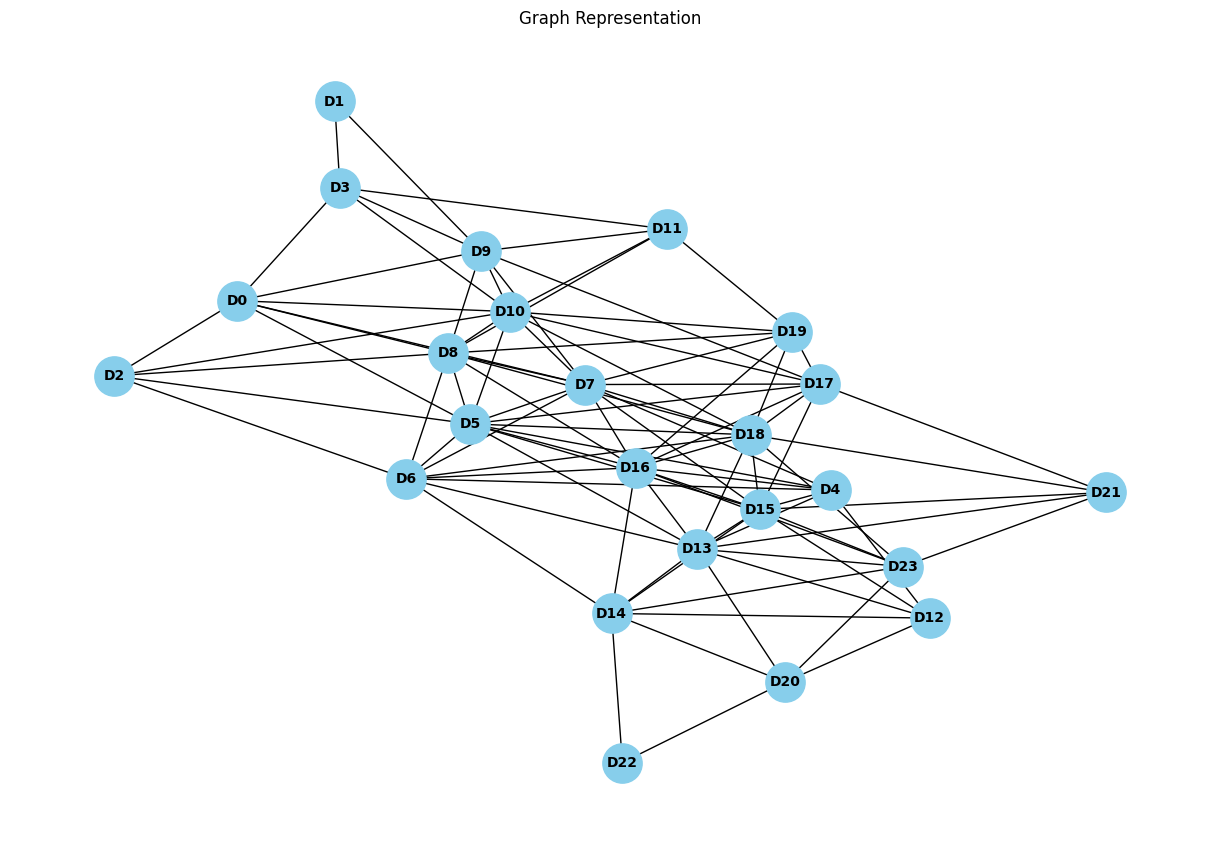

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# 定义邻接列表
edges = detector_connectivity

# 创建图
G = nx.Graph()

# 添加边
for node, neighbors in edges.items():
    for neighbor in neighbors:
        G.add_edge(node, f'D{neighbor}')

# 绘制图
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # 使用弹簧布局
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('Graph Representation')
plt.show()

### 按照连接边最少的顺序进行执行上述任务

In [22]:
detector_connectivity_length = {k:len(v) for k,v in detector_connectivity.items()}

In [23]:
def str_detector_to_int(detector:str):
    return int(detector[1:])

# detector_connectivity_length
## 当前计算得到的维度
current_distribution_dimensions = 0
## 当前已计算节点
currently_calculated_nodes = []
## 当前相邻的节点
current_neighboring_nodes = []
## 当前所计算的分布涉及的节点 [f"D{i}" for i in range(ml_decoder.detector_number)]
current_distribution_related_nodes = set()

# 第一步
init_min_nodes = min(detector_connectivity_length, key=detector_connectivity_length.get)
# unexecuted_nodes.remove(init_min_nodes)

currently_calculated_nodes.append(init_min_nodes)
current_distribution_related_nodes.add(init_min_nodes)
for node in currently_calculated_nodes:
    for i in detector_connectivity[node]:
        current_distribution_related_nodes.add(f"D{i}")

current_neighboring_nodes = [i for i in current_distribution_related_nodes if i not in currently_calculated_nodes]

print(currently_calculated_nodes)
print(current_distribution_related_nodes)
print(current_neighboring_nodes)

# 第二步
## 从current_neighboring_nodes中选择下一个计算的节点
# ## 选择相邻节点中，新增节点数最小的节点
# detector:str
print("--------------")
current_neightboring_nodes_new_nodes_lenth = {}
for neighbor in current_neighboring_nodes:
    ## 当前相邻节点的相邻节点数
    current_neighboring_neighboring_nodes = detector_connectivity[neighbor]
    ## 新增的节点
    new_nodes = [f"D{i}" for i in current_neighboring_neighboring_nodes if f"D{i}" not in current_distribution_related_nodes]
    # print(neighbor, new_nodes)
    current_neightboring_nodes_new_nodes_lenth[neighbor] = len(new_nodes)
print(current_neightboring_nodes_new_nodes_lenth)
# 选择最小新增边的节点
detector = min(current_neightboring_nodes_new_nodes_lenth, key=current_neightboring_nodes_new_nodes_lenth.get)
print(detector)
currently_calculated_nodes.append(detector)
current_distribution_related_nodes.add(detector)
for node in currently_calculated_nodes:
    for i in detector_connectivity[node]:
        current_distribution_related_nodes.add(f"D{i}")
current_neighboring_nodes = [i for i in current_distribution_related_nodes if i not in currently_calculated_nodes]

print(currently_calculated_nodes)
print(current_distribution_related_nodes)
print(current_neighboring_nodes)

['D1']
{'D3', 'D1', 'D9'}
['D3', 'D9']
--------------
{'D3': 3, 'D9': 6}
D3
['D1', 'D3']
{'D3', 'D10', 'D0', 'D1', 'D9', 'D11'}
['D10', 'D0', 'D9', 'D11']


写成循环的形式：
* 终止条件：len(currently_calculated_nodes) == ml_decoder.detector_number 或者是 for _ in range(ml_decoder.detector_number)

In [31]:
from typing import Dict, List, Set
## 当前计算得到的维度
current_distribution_dimensions = 0
currently_calculated_nodes = []
current_neighboring_nodes = []
current_distribution_related_nodes = set()

def add_neightboring_nodes(currently_calculated_nodes: List, current_distribution_related_nodes: Set, detector_connectivity: Dict):
    for node in currently_calculated_nodes:
        for i in detector_connectivity[node]:
            current_distribution_related_nodes.add(f"D{i}")
    return current_distribution_related_nodes

def get_current_neightboring_nodes_new_nodes_lenth(current_neighboring_nodes: List, current_distribution_related_nodes: Set, detector_connectivity:Dict):
    current_neightboring_nodes_new_nodes_lenth = {}
    print("current_neighboring_nodes:",current_neighboring_nodes)
    for neighbor in current_neighboring_nodes:
        ## 当前相邻节点的相邻节点数
        current_neighboring_neighboring_nodes = detector_connectivity[neighbor]
        ## 新增的节点
        new_nodes = [f"D{i}" for i in current_neighboring_neighboring_nodes if f"D{i}" not in current_distribution_related_nodes]
        # print(neighbor, new_nodes)
        current_neightboring_nodes_new_nodes_lenth[neighbor] = len(new_nodes)
    return current_neightboring_nodes_new_nodes_lenth

for step in range(ml_decoder.detector_number):
    print(f"step: {step}")
    if step == 0:
        detector = min(detector_connectivity_length, key=detector_connectivity_length.get)
    else:
        current_neightboring_nodes_new_nodes_lenth = get_current_neightboring_nodes_new_nodes_lenth(current_neighboring_nodes, current_distribution_related_nodes, detector_connectivity)
        detector = min(current_neightboring_nodes_new_nodes_lenth, key=current_neightboring_nodes_new_nodes_lenth.get)
    print(f"detector is:{detector}")
    currently_calculated_nodes.append(detector)
    current_distribution_related_nodes.add(detector)
    current_distribution_related_nodes = add_neightboring_nodes(currently_calculated_nodes, current_distribution_related_nodes, detector_connectivity)
    current_neighboring_nodes = [i for i in current_distribution_related_nodes if i not in currently_calculated_nodes]
    
    current_distribution_dimensions = (len(current_distribution_related_nodes) - len(currently_calculated_nodes))
    print(f"current_distribution_dimensions: {current_distribution_dimensions}, size is: {2**current_distribution_dimensions}")
    print(f"currently_calculated_nodes: {currently_calculated_nodes}")
    print(f"current_distribution_related_nodes: {current_distribution_related_nodes}")
    print(f"current_neighboring_nodes: {current_neighboring_nodes}")

step: 0
detector is:D1
current_distribution_dimensions: 2, size is: 4
currently_calculated_nodes: ['D1']
current_distribution_related_nodes: {'D3', 'D1', 'D9'}
current_neighboring_nodes: ['D3', 'D9']
step: 1
current_neighboring_nodes: ['D3', 'D9']
detector is:D3
current_distribution_dimensions: 4, size is: 16
currently_calculated_nodes: ['D1', 'D3']
current_distribution_related_nodes: {'D3', 'D10', 'D0', 'D1', 'D9', 'D11'}
current_neighboring_nodes: ['D10', 'D0', 'D9', 'D11']
step: 2
current_neighboring_nodes: ['D10', 'D0', 'D9', 'D11']
detector is:D11
current_distribution_dimensions: 5, size is: 32
currently_calculated_nodes: ['D1', 'D3', 'D11']
current_distribution_related_nodes: {'D3', 'D10', 'D8', 'D0', 'D19', 'D1', 'D9', 'D11'}
current_neighboring_nodes: ['D10', 'D8', 'D0', 'D19', 'D9']
step: 3
current_neighboring_nodes: ['D10', 'D8', 'D0', 'D19', 'D9']
detector is:D9
current_distribution_dimensions: 6, size is: 64
currently_calculated_nodes: ['D1', 'D3', 'D11', 'D9']
current_dist